In [1]:
### Install required libraries
!pip install pyyaml scikit-image trimesh matplotlib wandb deepdish plyfile gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.3/696.3 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00


In [2]:
### Dowload data
!gdown '1vp9-ulYJV1glKfgCtLiv7BkfEoThPu7C'
!unzip /content/shape_net_voxel_data_v1.zip
!mv shape_net_voxel_data_v1/ data/
!ls data | wc -l

Streaming output truncated to the last 5000 lines.
  inflating: shape_net_voxel_data_v1/shape_net_voxel_data_04379243_4f4ea0588e9444be30bbd4cddd04c77b.dd  
  inflating: shape_net_voxel_data_v1/shape_net_voxel_data_04379243_4f7c024d01141f23f51f77a6d7299806.dd  
  inflating: shape_net_voxel_data_v1/shape_net_voxel_data_04379243_4faf91d6e511e153b20565fa9224214d.dd  
  inflating: shape_net_voxel_data_v1/shape_net_voxel_data_04379243_4fb805fd299207e7848af3cb674ead1.dd  
  inflating: shape_net_voxel_data_v1/shape_net_voxel_data_04379243_504d908a55f3e0c764810cc21086da42.dd  
  inflating: shape_net_voxel_data_v1/shape_net_voxel_data_04379243_50894123f3f237c161062d371b5548c7.dd  
  inflating: shape_net_voxel_data_v1/shape_net_voxel_data_04379243_520fad3fdb9cba4f1f335cc23d448de8.dd  
  inflating: shape_net_voxel_data_v1/shape_net_voxel_data_04379243_5276058cfc1e139326392a5b643ed5e3.dd  
  inflating: shape_net_voxel_data_v1/shape_net_voxel_data_04379243_5407f938370ffd34390dcdc075aa60c5.dd  
  inf

In [3]:
import numpy as np
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from skimage import measure
import trimesh
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import yaml
import wandb
import deepdish as dd
import os

In [10]:
global_config = {
    'data': {
        'dataset_path': 'data/',  # default dataset path
        'batch_size': 64,
        'shuffle': True,
        'num_workers': 4,
        'class_code': '03001627',  # Class code -> Chairs: 03001627, Tables: 04379243
        'split_ratio': 0.8  # Training to testing ratio
    },
    'training': {
        'epochs': 100,
        'learning_rate': 1e-4,
        'l2_lambda': 1e-5,  # L2 regularization term
        'gamma': 0.97,  # Hyperparameter for modified BCE
        'checkpoint_freq': 20,  # Frequency (in epochs) to save model checkpoints
        'visualize_freq': 20  # Frequency (in epochs) to visualize network output
    },
    'model': {
        'latent_dim': 128,
        'type': 'VAE'
    }
}

In [11]:
class ShapeNetDataset(Dataset):
    def __init__(self, args):
        self.dataset_path = Path(args["dataset_path"])
        self.class_code = args["class_code"]

        ### Selecting the files for the speific class code mentioned in the config
        self.files = [
            file
            for file in self.dataset_path.glob("*.dd")
            if self.class_code == 'All' or self.class_code in file.stem
        ]
        self.batch_size = args["batch_size"]
        self.num_workers = args["num_workers"]
        self.shuffle = args["shuffle"]

        self.split_ratio = args["split_ratio"]

        num_files = len(self.files)
        split = int(np.floor(self.split_ratio * num_files))
        self.train_files, self.test_files = random_split(
            self.files, [split, num_files - split]
        )

        print(f"Found {len(self.files)} files for class {self.class_code}.")
        print(
            f"Training set size: {len(self.train_files)}, Testing set size: {len(self.test_files)}"
        )

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        voxel_data = dd.io.load(str(file_path))["data"]
        voxel_tensor = torch.tensor(voxel_data, dtype=torch.float32)

        ### Make the voxel grid using a right hand coordinate frame
        voxel_tensor = torch.permute(voxel_tensor, (2, 0, 1)).unsqueeze(0)

        ### Normalize the values of voxels to be 0 and 1
        voxel_tensor = voxel_tensor * 0.5 + 0.5
        return {"voxels": voxel_tensor}

    def worker_init_fn(self, worker_id):
        random_data = os.urandom(4)
        base_seed = int.from_bytes(random_data, byteorder="big")
        np.random.seed(base_seed + worker_id)

    ### Get the dataloader instance of the dataset
    def get_loader(self, train=True):
        files = self.train_files if train else self.test_files
        dataset = torch.utils.data.Subset(self, files.indices)
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=self.shuffle if train else False,
            worker_init_fn=self.worker_init_fn,
            drop_last=True,
        )


### Dataset -> Testing
config = {
        "dataset_path": "data/",
        "class_code": 'All',
        "batch_size": 32,
        "num_workers": 4,
        "shuffle": True,
        "split_ratio": 0.8,
    }
tmp_dataset = ShapeNetDataset(config)
tmp_train_loader = tmp_dataset.get_loader(train=True)
tmp_test_loader = tmp_dataset.get_loader(train=False)

Found 43783 files for class All.
Training set size: 35026, Testing set size: 8757


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
### A simple building block of the encoder network.
### Convolution -> BatchNormalization -> Activation
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(EncoderBlock, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm = nn.BatchNorm3d(out_channels)
        self.act = nn.ELU()

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        return x


### A simple building block of the encoder network.
### TransposeConvolution -> BatchNormalization -> Activation
class DecoderBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=3,
        stride=1,
        padding=0,
        output_padding=0,
        is_last_layer=False,
    ):
        super(DecoderBlock, self).__init__()
        self.conv = nn.ConvTranspose3d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            output_padding=output_padding,
        )
        self.is_last_layer = is_last_layer

        ### If this is the last layer in the decoder network, we don't want any ELUactivations
        if not self.is_last_layer:
            self.norm = nn.BatchNorm3d(out_channels)
            self.act = nn.ELU()

    def forward(self, x):
        x = self.conv(x)
        if not self.is_last_layer:
            x = self.norm(x)
            x = self.act(x)
        return x


### Linear module for latent code
class LinearBlock(nn.Module):
    def __init__(self, in_features, out_features, use_batchnorm=True):
        super(LinearBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.use_batchnorm = use_batchnorm
        if self.use_batchnorm:
            self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):
        x = self.fc(x)
        if self.use_batchnorm:
            x = self.bn(x)
        return x


class VoxelVAE(nn.Module):
    def __init__(self, args):
        super(VoxelVAE, self).__init__()
        self.latent_dim = args["latent_dim"]

        # Encoder
        self.encoder = nn.ModuleList(
            [
                EncoderBlock(
                    1, 8, kernel_size=3, stride=1, padding=0
                ),  # 32x32x32 -> 30x30x30
                EncoderBlock(
                    8, 16, kernel_size=3, stride=2, padding=1
                ),  # 30x30x30 -> 15x15x15
                EncoderBlock(
                    16, 32, kernel_size=3, stride=1, padding=0
                ),  # 15x15x15 -> 13x13x13
                EncoderBlock(
                    32, 64, kernel_size=3, stride=2, padding=1
                ),  # 13x13x13 -> 7x7x7
            ]
        )

        self.fc_mu = LinearBlock(64 * 7 * 7 * 7, self.latent_dim)
        self.fc_logvar = LinearBlock(64 * 7 * 7 * 7, self.latent_dim)

        # Decoder
        self.fc_decode = LinearBlock(self.latent_dim, 64 * 7 * 7 * 7)
        self.decoder = nn.ModuleList(
            [
                DecoderBlock(
                    64, 64, kernel_size=3, stride=1, padding=1
                ),  # 7x7x7 -> 7x7x7
                DecoderBlock(
                    64, 32, kernel_size=3, stride=2, padding=0
                ),  # 7x7x7 -> 15x15x15
                DecoderBlock(
                    32, 16, kernel_size=3, stride=1, padding=1
                ),  # 15x15x15 -> 15x15x15
                DecoderBlock(
                    16, 8, kernel_size=4, stride=2, padding=0, output_padding=0
                ),  # 15x15x15 -> 32x32x32
                DecoderBlock(
                    8, 1, kernel_size=3, stride=1, padding=1, is_last_layer=True
                ),  # 32x32x32 -> 32x32x32 (output layer)
            ]
        )

    def encode(self, x):
        for block in self.encoder:
            x = block(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    ### Does the reparametrization technic in training VAEs, ensuring a differentiability through the stochastic sampling process
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(x.size(0), 64, 7, 7, 7)
        for block in self.decoder:
            x = block(x)
        x = torch.sigmoid(x)  ### Ensure output is in [0, 1]
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


In [13]:
### Runs marching cubes on a voxel grid and saves the generated mesh
def save_voxel_as_mesh(voxel, file_path):
    vertices, faces, normals, _ = measure.marching_cubes(voxel, level=0.5)

    mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_normals=normals)

    mesh.export(file_path)
    print(f"Mesh saved to {file_path}")

In [14]:
class TrainerVAE:
    def __init__(self, config, run_name):
        self.config = config

        if torch.cuda.is_available():
            self.device = torch.device("cuda")
            print("Using CUDA")
        elif torch.backends.mps.is_built() and torch.backends.mps.is_available():
            self.device = torch.device("mps")
            print("Using MPS")
        else:
            self.device = torch.device("cpu")
            print("Using CPU")

        ### Initialize dataset and dataloader
        self.dataset = ShapeNetDataset(args=config["data"])
        self.train_loader = self.dataset.get_loader(train=True)
        self.test_loader = self.dataset.get_loader(train=False)

        ### Initialize model
        self.model = VoxelVAE(args=config["model"]).to(self.device)
        wandb.watch(self.model)

        self.learning_rate = float(config["training"]["learning_rate"])

        ### Initialize optimizer
        self.optimizer = optim.Adam(
            self.model.parameters(), lr=self.learning_rate, weight_decay=1e-5
        )

        ### Create the necessary directories
        self.checkpoint_freq = config["training"]["checkpoint_freq"]
        self.visualize_freq = config["training"]["visualize_freq"]

        self.checkpoint_dir = Path("checkpoints") / Path(run_name)
        self.vis_dir = Path("vis") / Path(run_name)

        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)
        self.vis_dir.mkdir(parents=True, exist_ok=True)

    ### Computes the loss for one batch
    def step_loss(self, recon_x, x, mu, logvar):

        ### Defines the modified BCE loss based on the mentioned paper
        def weighted_binary_crossentropy(output, target):
            return (
                -(
                    98.0 * target * torch.log(output)
                    + 2.0 * (1.0 - target) * torch.log(1.0 - output)
                )
                / 100.0
            )

        recon_x = torch.clamp(recon_x, 1e-7, 1.0 - 1e-7)

        ### Reconstruction Loss using weighted binary cross-entropy
        voxel_loss = torch.mean(weighted_binary_crossentropy(recon_x, x).float())

        ### KL Divergence loss
        kl_loss = -0.5 * torch.mean(1 + 2 * logvar - mu.pow(2) - (2 * logvar).exp())

        return voxel_loss, kl_loss

    ### Performs one step of training (for one batch), both forward and backward
    def train_step(self, data):
        data = data.to(self.device)
        self.optimizer.zero_grad()
        recon_batch, mu, logvar = self.model(data)
        voxel_loss_step, kl_loss_step = self.step_loss(recon_batch, data, mu, logvar)
        loss_step = voxel_loss_step + kl_loss_step
        loss_step.backward()
        self.optimizer.step()
        return (
            loss_step.item(),
            voxel_loss_step.item(),
            kl_loss_step.item(),
            recon_batch,
            mu,
            logvar,
        )

    ### Performs one epoch of training
    def train_epoch(self, epoch):
        self.model.train()

        loss_epoch = 0
        voxel_loss_epoch = 0
        kl_loss_epoch = 0

        p_bar = tqdm(
            self.train_loader,
            total=len(self.train_loader),
        )
        for i, batch in enumerate(p_bar):
            data = batch["voxels"]
            loss_step, voxel_loss_step, kl_loss_step, _, _, _ = self.train_step(data)

            loss_epoch += loss_step
            voxel_loss_epoch += voxel_loss_step
            kl_loss_epoch += kl_loss_step

            p_bar.set_description(
                f"Epoch [{epoch}/{self.config['training']['epochs']}], Step Loss: {loss_step:.4f}, Step Voxel Loss: {voxel_loss_step:.4f}, Step KL Loss: {kl_loss_step:.4f}"
            )

        avg_loss = loss_epoch / len(self.train_loader)
        avg_voxel_loss = voxel_loss_epoch / len(self.train_loader)
        avg_kl_loss = kl_loss_epoch / len(self.train_loader)

        return avg_loss, avg_voxel_loss, avg_kl_loss

    ### Performs testing of the model after training is finished
    def test(self):
        self.model.eval()

        total_test_loss = 0
        total_kl_loss = 0
        total_voxel_loss = 0

        with torch.no_grad():
            for batch in tqdm(self.test_loader, desc="Testing"):
                data = batch["voxels"].to(self.device)
                recon_batch, mu, logvar = self.model(data)
                voxel_loss, kl_loss = self.step_loss(recon_batch, data, mu, logvar)

                total_kl_loss += kl_loss
                total_voxel_loss += voxel_loss
                total_test_loss += voxel_loss + kl_loss

        avg_test_loss = total_test_loss / len(self.test_loader.dataset)
        avg_voxel_loss = total_voxel_loss / len(self.test_loader.dataset)
        avg_kl_loss = total_kl_loss / len(self.test_loader.dataset)

        return avg_kl_loss, avg_voxel_loss, avg_test_loss

    ### Samples a random vector from the normal distribution of N(0, 1), and feeds it through
    ### the decoder, generating a voxel grid. Then uses marching cubes to generate a mesh and save it.
    def sample_and_generate_mesh(self, epoch):
        self.model.eval()

        with torch.no_grad():
            z = torch.randn(1, self.model.latent_dim).to(self.device)
            voxel = self.model.decode(z).cpu().numpy()
            voxel = voxel.squeeze()

            file_path = self.vis_dir / f"sampled_mesh_epoch-{epoch}.obj"

            ### Marching cubes and saving
            save_voxel_as_mesh(voxel, file_path)

            ### Logging to WandB
            wandb.log(
                {"Sampled Mesh": [wandb.Object3D(open(file_path))]},
                step=epoch,
            )

    ### Samples 4 random vectors from the normal distribution of N(0, 1), and feeds it through
    ### the decoder, generating a voxel grid. Then plots and saves the voxels.
    def sample_and_visualize(self, epoch):

        self.model.eval()

        with torch.no_grad():
            z = torch.randn(4, self.model.latent_dim).to(self.device)
            samples = self.model.decode(z).cpu().numpy()
            samples = samples.squeeze()

            fig = plt.figure(figsize=(40, 20))

            for i in range(samples.shape[0]):
                sample = samples[i].copy()
                ax = fig.add_subplot(1, 4, i + 1, projection="3d")
                ax.voxels(sample > 0.5, facecolors="cyan", edgecolor="k")
                ax.set_axis_off()
                ax.view_init(elev=30, azim=45)

            plt.suptitle(f"Samples at Epoch {epoch}")
            vis_path = self.vis_dir / f"samples_epoch_{epoch}.png"
            plt.savefig(vis_path)
            plt.close(fig)

            ### Logging to WandB
            wandb.log(
                {"Samples": [wandb.Image(str(vis_path))]},
                step=epoch,
            )

    def run(self):

        for epoch in range(1, self.config["training"]["epochs"] + 1):
            avg_loss_epoch, avg_voxel_loss_epoch, avg_kl_loss_epoch = self.train_epoch(
                epoch
            )

            print(
                f"Epoch [{epoch}/{self.config['training']['epochs']}], Epoch Loss: {avg_loss_epoch:.4f}, Epoch Voxel Loss: {avg_voxel_loss_epoch:.4f}, Epoch KL Loss: {avg_kl_loss_epoch:.4f}"
            )

            wandb.log(
                {
                    "Epoch Train Loss": avg_loss_epoch,
                    "Epoch BCE Loss": avg_voxel_loss_epoch,
                    "Epoch KLD Loss": avg_kl_loss_epoch,
                },
                step=epoch,
            )

            ### Saving model checkpoint
            if epoch % self.checkpoint_freq == 0:
                checkpoint_path = self.checkpoint_dir / f"vae_epoch_{epoch}.pth"
                torch.save(self.model.state_dict(), checkpoint_path)
                print(f"Model checkpoint saved to {checkpoint_path}")

            ### Visualize the network output
            if epoch % self.visualize_freq == 0:
                self.sample_and_visualize(epoch)
                self.sample_and_generate_mesh(epoch)

        ### Testing on the test set
        avg_kl_loss, avg_voxel_loss, avg_test_loss = self.test()
        print(
            f"Test Loss: {avg_test_loss:.4f}, Voxel (Reconstruction) Loss: {avg_voxel_loss:.4f}, KL Loss: {avg_kl_loss:.4f}"
        )


In [18]:
wandb.init(project="3DGen-Task", config=global_config, name='Colab-Chairs')
trainer = TrainerVAE(global_config, run_name='Colab-Chairs')
trainer.run()
wandb.finish()

### WandB API Key: 49e8568961ef9647510117f85b2926ff03acada5

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Using CUDA
Found 6778 files for class 03001627.
Training set size: 5422, Testing set size: 1356


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/84 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch [1/100

Epoch [1/100], Epoch Loss: 1.3666, Epoch Voxel Loss: 0.0485, Epoch KL Loss: 1.3181


Epoch [2/100], Step Loss: 0.9619, Step Voxel Loss: 0.0214, Step KL Loss: 0.9405: 100%|██████████| 84/84 [00:17<00:00,  4.74it/s]


Epoch [2/100], Epoch Loss: 0.9733, Epoch Voxel Loss: 0.0234, Epoch KL Loss: 0.9499


Epoch [3/100], Step Loss: 0.8805, Step Voxel Loss: 0.0196, Step KL Loss: 0.8609: 100%|██████████| 84/84 [00:20<00:00,  4.19it/s]


Epoch [3/100], Epoch Loss: 0.8869, Epoch Voxel Loss: 0.0204, Epoch KL Loss: 0.8666


Epoch [4/100], Step Loss: 0.9028, Step Voxel Loss: 0.0193, Step KL Loss: 0.8834: 100%|██████████| 84/84 [00:18<00:00,  4.43it/s]


Epoch [4/100], Epoch Loss: 0.8346, Epoch Voxel Loss: 0.0192, Epoch KL Loss: 0.8155


Epoch [5/100], Step Loss: 0.7753, Step Voxel Loss: 0.0179, Step KL Loss: 0.7574: 100%|██████████| 84/84 [00:17<00:00,  4.67it/s]


Epoch [5/100], Epoch Loss: 0.8030, Epoch Voxel Loss: 0.0181, Epoch KL Loss: 0.7848


Epoch [6/100], Step Loss: 0.7496, Step Voxel Loss: 0.0174, Step KL Loss: 0.7322: 100%|██████████| 84/84 [00:21<00:00,  3.91it/s]


Epoch [6/100], Epoch Loss: 0.7729, Epoch Voxel Loss: 0.0176, Epoch KL Loss: 0.7553


Epoch [7/100], Step Loss: 0.9229, Step Voxel Loss: 0.0200, Step KL Loss: 0.9029: 100%|██████████| 84/84 [00:20<00:00,  4.07it/s]


Epoch [7/100], Epoch Loss: 0.8556, Epoch Voxel Loss: 0.0175, Epoch KL Loss: 0.8381


Epoch [8/100], Step Loss: 0.7323, Step Voxel Loss: 0.0165, Step KL Loss: 0.7158: 100%|██████████| 84/84 [00:18<00:00,  4.63it/s]


Epoch [8/100], Epoch Loss: 0.8337, Epoch Voxel Loss: 0.0173, Epoch KL Loss: 0.8163


Epoch [9/100], Step Loss: 0.7641, Step Voxel Loss: 0.0167, Step KL Loss: 0.7474: 100%|██████████| 84/84 [00:20<00:00,  4.18it/s]


Epoch [9/100], Epoch Loss: 0.7552, Epoch Voxel Loss: 0.0176, Epoch KL Loss: 0.7376


Epoch [10/100], Step Loss: 0.7781, Step Voxel Loss: 0.0156, Step KL Loss: 0.7625: 100%|██████████| 84/84 [00:22<00:00,  3.74it/s]


Epoch [10/100], Epoch Loss: 0.7882, Epoch Voxel Loss: 0.0164, Epoch KL Loss: 0.7718


Epoch [11/100], Step Loss: 0.6625, Step Voxel Loss: 0.0156, Step KL Loss: 0.6469: 100%|██████████| 84/84 [00:20<00:00,  4.18it/s]


Epoch [11/100], Epoch Loss: 0.7522, Epoch Voxel Loss: 0.0165, Epoch KL Loss: 0.7357


Epoch [12/100], Step Loss: 0.7980, Step Voxel Loss: 0.0155, Step KL Loss: 0.7825: 100%|██████████| 84/84 [00:19<00:00,  4.22it/s]


Epoch [12/100], Epoch Loss: 0.7175, Epoch Voxel Loss: 0.0158, Epoch KL Loss: 0.7017


Epoch [13/100], Step Loss: 0.6276, Step Voxel Loss: 0.0138, Step KL Loss: 0.6138: 100%|██████████| 84/84 [00:20<00:00,  4.19it/s]


Epoch [13/100], Epoch Loss: 0.6829, Epoch Voxel Loss: 0.0153, Epoch KL Loss: 0.6676


Epoch [14/100], Step Loss: 0.6283, Step Voxel Loss: 0.0142, Step KL Loss: 0.6140: 100%|██████████| 84/84 [00:18<00:00,  4.64it/s]


Epoch [14/100], Epoch Loss: 0.6553, Epoch Voxel Loss: 0.0151, Epoch KL Loss: 0.6402


Epoch [15/100], Step Loss: 0.6383, Step Voxel Loss: 0.0150, Step KL Loss: 0.6233: 100%|██████████| 84/84 [00:24<00:00,  3.48it/s]


Epoch [15/100], Epoch Loss: 0.6281, Epoch Voxel Loss: 0.0149, Epoch KL Loss: 0.6133


Epoch [16/100], Step Loss: 0.6373, Step Voxel Loss: 0.0146, Step KL Loss: 0.6226: 100%|██████████| 84/84 [00:20<00:00,  4.17it/s]


Epoch [16/100], Epoch Loss: 0.6626, Epoch Voxel Loss: 0.0148, Epoch KL Loss: 0.6478


Epoch [17/100], Step Loss: 0.6346, Step Voxel Loss: 0.0145, Step KL Loss: 0.6201: 100%|██████████| 84/84 [00:17<00:00,  4.79it/s]


Epoch [17/100], Epoch Loss: 0.6172, Epoch Voxel Loss: 0.0149, Epoch KL Loss: 0.6023


Epoch [18/100], Step Loss: 0.6703, Step Voxel Loss: 0.0164, Step KL Loss: 0.6539: 100%|██████████| 84/84 [00:17<00:00,  4.69it/s]


Epoch [18/100], Epoch Loss: 0.6024, Epoch Voxel Loss: 0.0144, Epoch KL Loss: 0.5880


Epoch [19/100], Step Loss: 0.6123, Step Voxel Loss: 0.0138, Step KL Loss: 0.5985: 100%|██████████| 84/84 [00:17<00:00,  4.79it/s]


Epoch [19/100], Epoch Loss: 0.5844, Epoch Voxel Loss: 0.0142, Epoch KL Loss: 0.5702


Epoch [20/100], Step Loss: 0.5361, Step Voxel Loss: 0.0143, Step KL Loss: 0.5219: 100%|██████████| 84/84 [00:18<00:00,  4.54it/s]


Epoch [20/100], Epoch Loss: 0.5635, Epoch Voxel Loss: 0.0141, Epoch KL Loss: 0.5494
Model checkpoint saved to checkpoints/Colab-Chairs/vae_epoch_20.pth
Mesh saved to vis/Colab-Chairs/sampled_mesh_epoch-20.obj


Epoch [21/100], Step Loss: 0.6776, Step Voxel Loss: 0.0147, Step KL Loss: 0.6629: 100%|██████████| 84/84 [00:19<00:00,  4.35it/s]


Epoch [21/100], Epoch Loss: 0.6237, Epoch Voxel Loss: 0.0143, Epoch KL Loss: 0.6094


Epoch [22/100], Step Loss: 0.5323, Step Voxel Loss: 0.0142, Step KL Loss: 0.5182: 100%|██████████| 84/84 [00:17<00:00,  4.72it/s]


Epoch [22/100], Epoch Loss: 0.5794, Epoch Voxel Loss: 0.0144, Epoch KL Loss: 0.5650


Epoch [23/100], Step Loss: 0.5298, Step Voxel Loss: 0.0145, Step KL Loss: 0.5152: 100%|██████████| 84/84 [00:16<00:00,  4.95it/s]


Epoch [23/100], Epoch Loss: 0.5473, Epoch Voxel Loss: 0.0138, Epoch KL Loss: 0.5335


Epoch [24/100], Step Loss: 0.6028, Step Voxel Loss: 0.0134, Step KL Loss: 0.5894: 100%|██████████| 84/84 [00:16<00:00,  5.20it/s]


Epoch [24/100], Epoch Loss: 0.5585, Epoch Voxel Loss: 0.0140, Epoch KL Loss: 0.5445


Epoch [25/100], Step Loss: 0.5969, Step Voxel Loss: 0.0126, Step KL Loss: 0.5843: 100%|██████████| 84/84 [00:16<00:00,  5.24it/s]


Epoch [25/100], Epoch Loss: 0.6196, Epoch Voxel Loss: 0.0140, Epoch KL Loss: 0.6056


Epoch [26/100], Step Loss: 0.5500, Step Voxel Loss: 0.0139, Step KL Loss: 0.5361: 100%|██████████| 84/84 [00:16<00:00,  4.97it/s]


Epoch [26/100], Epoch Loss: 0.5684, Epoch Voxel Loss: 0.0140, Epoch KL Loss: 0.5544


Epoch [27/100], Step Loss: 0.5277, Step Voxel Loss: 0.0139, Step KL Loss: 0.5138: 100%|██████████| 84/84 [00:17<00:00,  4.73it/s]


Epoch [27/100], Epoch Loss: 0.5305, Epoch Voxel Loss: 0.0141, Epoch KL Loss: 0.5164


Epoch [28/100], Step Loss: 0.5163, Step Voxel Loss: 0.0135, Step KL Loss: 0.5027: 100%|██████████| 84/84 [00:17<00:00,  4.70it/s]


Epoch [28/100], Epoch Loss: 0.5365, Epoch Voxel Loss: 0.0143, Epoch KL Loss: 0.5222


Epoch [29/100], Step Loss: 0.4882, Step Voxel Loss: 0.0135, Step KL Loss: 0.4746: 100%|██████████| 84/84 [00:17<00:00,  4.72it/s]


Epoch [29/100], Epoch Loss: 0.5090, Epoch Voxel Loss: 0.0139, Epoch KL Loss: 0.4951


Epoch [30/100], Step Loss: 0.4563, Step Voxel Loss: 0.0134, Step KL Loss: 0.4429: 100%|██████████| 84/84 [00:17<00:00,  4.94it/s]


Epoch [30/100], Epoch Loss: 0.4947, Epoch Voxel Loss: 0.0140, Epoch KL Loss: 0.4807


Epoch [31/100], Step Loss: 0.5071, Step Voxel Loss: 0.0140, Step KL Loss: 0.4931: 100%|██████████| 84/84 [00:16<00:00,  5.17it/s]


Epoch [31/100], Epoch Loss: 0.4767, Epoch Voxel Loss: 0.0139, Epoch KL Loss: 0.4629


Epoch [32/100], Step Loss: 0.4384, Step Voxel Loss: 0.0126, Step KL Loss: 0.4258: 100%|██████████| 84/84 [00:16<00:00,  5.24it/s]


Epoch [32/100], Epoch Loss: 0.4735, Epoch Voxel Loss: 0.0139, Epoch KL Loss: 0.4596


Epoch [33/100], Step Loss: 0.4621, Step Voxel Loss: 0.0139, Step KL Loss: 0.4482: 100%|██████████| 84/84 [00:16<00:00,  5.01it/s]


Epoch [33/100], Epoch Loss: 0.4584, Epoch Voxel Loss: 0.0138, Epoch KL Loss: 0.4446


Epoch [34/100], Step Loss: 0.4822, Step Voxel Loss: 0.0178, Step KL Loss: 0.4645: 100%|██████████| 84/84 [00:17<00:00,  4.70it/s]


Epoch [34/100], Epoch Loss: 0.4490, Epoch Voxel Loss: 0.0138, Epoch KL Loss: 0.4353


Epoch [35/100], Step Loss: 0.4242, Step Voxel Loss: 0.0135, Step KL Loss: 0.4107: 100%|██████████| 84/84 [00:17<00:00,  4.67it/s]


Epoch [35/100], Epoch Loss: 0.4441, Epoch Voxel Loss: 0.0139, Epoch KL Loss: 0.4302


Epoch [36/100], Step Loss: 0.4887, Step Voxel Loss: 0.0128, Step KL Loss: 0.4759: 100%|██████████| 84/84 [00:17<00:00,  4.71it/s]


Epoch [36/100], Epoch Loss: 0.4330, Epoch Voxel Loss: 0.0138, Epoch KL Loss: 0.4192


Epoch [37/100], Step Loss: 0.4386, Step Voxel Loss: 0.0146, Step KL Loss: 0.4240: 100%|██████████| 84/84 [00:19<00:00,  4.25it/s]


Epoch [37/100], Epoch Loss: 0.4451, Epoch Voxel Loss: 0.0139, Epoch KL Loss: 0.4312


Epoch [38/100], Step Loss: 0.3835, Step Voxel Loss: 0.0137, Step KL Loss: 0.3698: 100%|██████████| 84/84 [00:21<00:00,  3.97it/s]


Epoch [38/100], Epoch Loss: 0.4245, Epoch Voxel Loss: 0.0139, Epoch KL Loss: 0.4105


Epoch [39/100], Step Loss: 0.4750, Step Voxel Loss: 0.0149, Step KL Loss: 0.4600: 100%|██████████| 84/84 [00:18<00:00,  4.62it/s]


Epoch [39/100], Epoch Loss: 0.4262, Epoch Voxel Loss: 0.0140, Epoch KL Loss: 0.4122


Epoch [40/100], Step Loss: 0.4628, Step Voxel Loss: 0.0160, Step KL Loss: 0.4468: 100%|██████████| 84/84 [00:18<00:00,  4.67it/s]


Epoch [40/100], Epoch Loss: 0.4547, Epoch Voxel Loss: 0.0148, Epoch KL Loss: 0.4399
Model checkpoint saved to checkpoints/Colab-Chairs/vae_epoch_40.pth
Mesh saved to vis/Colab-Chairs/sampled_mesh_epoch-40.obj


Epoch [41/100], Step Loss: 0.4814, Step Voxel Loss: 0.0162, Step KL Loss: 0.4652: 100%|██████████| 84/84 [00:15<00:00,  5.32it/s]


Epoch [41/100], Epoch Loss: 0.4290, Epoch Voxel Loss: 0.0148, Epoch KL Loss: 0.4142


Epoch [42/100], Step Loss: 0.4347, Step Voxel Loss: 0.0134, Step KL Loss: 0.4213: 100%|██████████| 84/84 [00:16<00:00,  5.15it/s]


Epoch [42/100], Epoch Loss: 0.4104, Epoch Voxel Loss: 0.0145, Epoch KL Loss: 0.3958


Epoch [43/100], Step Loss: 0.3340, Step Voxel Loss: 0.0133, Step KL Loss: 0.3206: 100%|██████████| 84/84 [00:16<00:00,  4.96it/s]


Epoch [43/100], Epoch Loss: 0.3943, Epoch Voxel Loss: 0.0145, Epoch KL Loss: 0.3798


Epoch [44/100], Step Loss: 0.3588, Step Voxel Loss: 0.0140, Step KL Loss: 0.3448: 100%|██████████| 84/84 [00:17<00:00,  4.74it/s]


Epoch [44/100], Epoch Loss: 0.3815, Epoch Voxel Loss: 0.0142, Epoch KL Loss: 0.3674


Epoch [45/100], Step Loss: 0.4572, Step Voxel Loss: 0.0137, Step KL Loss: 0.4436: 100%|██████████| 84/84 [00:17<00:00,  4.70it/s]


Epoch [45/100], Epoch Loss: 0.4289, Epoch Voxel Loss: 0.0147, Epoch KL Loss: 0.4142


Epoch [46/100], Step Loss: 0.3814, Step Voxel Loss: 0.0142, Step KL Loss: 0.3673: 100%|██████████| 84/84 [00:17<00:00,  4.73it/s]


Epoch [46/100], Epoch Loss: 0.4221, Epoch Voxel Loss: 0.0147, Epoch KL Loss: 0.4074


Epoch [47/100], Step Loss: 0.3511, Step Voxel Loss: 0.0143, Step KL Loss: 0.3368: 100%|██████████| 84/84 [00:17<00:00,  4.76it/s]


Epoch [47/100], Epoch Loss: 0.3913, Epoch Voxel Loss: 0.0146, Epoch KL Loss: 0.3767


Epoch [48/100], Step Loss: 0.3652, Step Voxel Loss: 0.0137, Step KL Loss: 0.3514: 100%|██████████| 84/84 [00:16<00:00,  5.22it/s]


Epoch [48/100], Epoch Loss: 0.3797, Epoch Voxel Loss: 0.0145, Epoch KL Loss: 0.3652


Epoch [49/100], Step Loss: 0.3825, Step Voxel Loss: 0.0151, Step KL Loss: 0.3674: 100%|██████████| 84/84 [00:16<00:00,  5.16it/s]


Epoch [49/100], Epoch Loss: 0.3662, Epoch Voxel Loss: 0.0144, Epoch KL Loss: 0.3518


Epoch [50/100], Step Loss: 0.3246, Step Voxel Loss: 0.0150, Step KL Loss: 0.3095: 100%|██████████| 84/84 [00:17<00:00,  4.92it/s]


Epoch [50/100], Epoch Loss: 0.3519, Epoch Voxel Loss: 0.0148, Epoch KL Loss: 0.3371


Epoch [51/100], Step Loss: 0.3229, Step Voxel Loss: 0.0151, Step KL Loss: 0.3078: 100%|██████████| 84/84 [00:17<00:00,  4.78it/s]


Epoch [51/100], Epoch Loss: 0.3398, Epoch Voxel Loss: 0.0149, Epoch KL Loss: 0.3249


Epoch [52/100], Step Loss: 0.3359, Step Voxel Loss: 0.0151, Step KL Loss: 0.3207: 100%|██████████| 84/84 [00:17<00:00,  4.67it/s]


Epoch [52/100], Epoch Loss: 0.3664, Epoch Voxel Loss: 0.0149, Epoch KL Loss: 0.3515


Epoch [53/100], Step Loss: 0.3295, Step Voxel Loss: 0.0141, Step KL Loss: 0.3154: 100%|██████████| 84/84 [00:17<00:00,  4.72it/s]


Epoch [53/100], Epoch Loss: 0.3359, Epoch Voxel Loss: 0.0147, Epoch KL Loss: 0.3212


Epoch [54/100], Step Loss: 0.2913, Step Voxel Loss: 0.0141, Step KL Loss: 0.2772: 100%|██████████| 84/84 [00:17<00:00,  4.69it/s]


Epoch [54/100], Epoch Loss: 0.3345, Epoch Voxel Loss: 0.0149, Epoch KL Loss: 0.3195


Epoch [55/100], Step Loss: 0.3486, Step Voxel Loss: 0.0151, Step KL Loss: 0.3336: 100%|██████████| 84/84 [00:16<00:00,  4.99it/s]


Epoch [55/100], Epoch Loss: 0.3279, Epoch Voxel Loss: 0.0147, Epoch KL Loss: 0.3132


Epoch [56/100], Step Loss: 0.2867, Step Voxel Loss: 0.0137, Step KL Loss: 0.2731: 100%|██████████| 84/84 [00:16<00:00,  5.23it/s]


Epoch [56/100], Epoch Loss: 0.3148, Epoch Voxel Loss: 0.0149, Epoch KL Loss: 0.2999


Epoch [57/100], Step Loss: 0.3084, Step Voxel Loss: 0.0156, Step KL Loss: 0.2929: 100%|██████████| 84/84 [00:16<00:00,  5.21it/s]


Epoch [57/100], Epoch Loss: 0.3215, Epoch Voxel Loss: 0.0152, Epoch KL Loss: 0.3064


Epoch [58/100], Step Loss: 0.3474, Step Voxel Loss: 0.0145, Step KL Loss: 0.3329: 100%|██████████| 84/84 [00:16<00:00,  4.95it/s]


Epoch [58/100], Epoch Loss: 0.3075, Epoch Voxel Loss: 0.0151, Epoch KL Loss: 0.2924


Epoch [59/100], Step Loss: 0.2769, Step Voxel Loss: 0.0152, Step KL Loss: 0.2617: 100%|██████████| 84/84 [00:17<00:00,  4.68it/s]


Epoch [59/100], Epoch Loss: 0.2974, Epoch Voxel Loss: 0.0153, Epoch KL Loss: 0.2821


Epoch [60/100], Step Loss: 0.2817, Step Voxel Loss: 0.0168, Step KL Loss: 0.2649: 100%|██████████| 84/84 [00:17<00:00,  4.74it/s]


Epoch [60/100], Epoch Loss: 0.3007, Epoch Voxel Loss: 0.0155, Epoch KL Loss: 0.2851
Model checkpoint saved to checkpoints/Colab-Chairs/vae_epoch_60.pth
Mesh saved to vis/Colab-Chairs/sampled_mesh_epoch-60.obj


Epoch [61/100], Step Loss: 0.2453, Step Voxel Loss: 0.0149, Step KL Loss: 0.2304: 100%|██████████| 84/84 [00:17<00:00,  4.74it/s]


Epoch [61/100], Epoch Loss: 0.2876, Epoch Voxel Loss: 0.0155, Epoch KL Loss: 0.2721


Epoch [62/100], Step Loss: 0.3044, Step Voxel Loss: 0.0158, Step KL Loss: 0.2886: 100%|██████████| 84/84 [00:18<00:00,  4.66it/s]


Epoch [62/100], Epoch Loss: 0.2882, Epoch Voxel Loss: 0.0158, Epoch KL Loss: 0.2724


Epoch [63/100], Step Loss: 0.2887, Step Voxel Loss: 0.0146, Step KL Loss: 0.2741: 100%|██████████| 84/84 [00:18<00:00,  4.66it/s]


Epoch [63/100], Epoch Loss: 0.2872, Epoch Voxel Loss: 0.0157, Epoch KL Loss: 0.2714


Epoch [64/100], Step Loss: 0.2589, Step Voxel Loss: 0.0162, Step KL Loss: 0.2426: 100%|██████████| 84/84 [00:17<00:00,  4.71it/s]


Epoch [64/100], Epoch Loss: 0.2748, Epoch Voxel Loss: 0.0156, Epoch KL Loss: 0.2592


Epoch [65/100], Step Loss: 0.2530, Step Voxel Loss: 0.0191, Step KL Loss: 0.2339: 100%|██████████| 84/84 [00:16<00:00,  4.96it/s]


Epoch [65/100], Epoch Loss: 0.2717, Epoch Voxel Loss: 0.0159, Epoch KL Loss: 0.2557


Epoch [66/100], Step Loss: 0.2397, Step Voxel Loss: 0.0176, Step KL Loss: 0.2221: 100%|██████████| 84/84 [00:17<00:00,  4.93it/s]


Epoch [66/100], Epoch Loss: 0.2655, Epoch Voxel Loss: 0.0160, Epoch KL Loss: 0.2496


Epoch [67/100], Step Loss: 0.2357, Step Voxel Loss: 0.0155, Step KL Loss: 0.2202: 100%|██████████| 84/84 [00:16<00:00,  5.07it/s]


Epoch [67/100], Epoch Loss: 0.2576, Epoch Voxel Loss: 0.0160, Epoch KL Loss: 0.2416


Epoch [68/100], Step Loss: 0.2475, Step Voxel Loss: 0.0161, Step KL Loss: 0.2313: 100%|██████████| 84/84 [00:16<00:00,  5.08it/s]


Epoch [68/100], Epoch Loss: 0.2527, Epoch Voxel Loss: 0.0162, Epoch KL Loss: 0.2365


Epoch [69/100], Step Loss: 0.2476, Step Voxel Loss: 0.0158, Step KL Loss: 0.2317: 100%|██████████| 84/84 [00:17<00:00,  4.92it/s]


Epoch [69/100], Epoch Loss: 0.2467, Epoch Voxel Loss: 0.0165, Epoch KL Loss: 0.2303


Epoch [70/100], Step Loss: 0.2332, Step Voxel Loss: 0.0198, Step KL Loss: 0.2134: 100%|██████████| 84/84 [00:18<00:00,  4.67it/s]


Epoch [70/100], Epoch Loss: 0.2393, Epoch Voxel Loss: 0.0164, Epoch KL Loss: 0.2229


Epoch [71/100], Step Loss: 0.2002, Step Voxel Loss: 0.0162, Step KL Loss: 0.1840: 100%|██████████| 84/84 [00:18<00:00,  4.66it/s]


Epoch [71/100], Epoch Loss: 0.2300, Epoch Voxel Loss: 0.0165, Epoch KL Loss: 0.2135


Epoch [72/100], Step Loss: 0.2143, Step Voxel Loss: 0.0161, Step KL Loss: 0.1982: 100%|██████████| 84/84 [00:17<00:00,  4.69it/s]


Epoch [72/100], Epoch Loss: 0.2370, Epoch Voxel Loss: 0.0168, Epoch KL Loss: 0.2202


Epoch [73/100], Step Loss: 0.2007, Step Voxel Loss: 0.0176, Step KL Loss: 0.1831: 100%|██████████| 84/84 [00:18<00:00,  4.66it/s]


Epoch [73/100], Epoch Loss: 0.2337, Epoch Voxel Loss: 0.0172, Epoch KL Loss: 0.2165


Epoch [74/100], Step Loss: 0.2062, Step Voxel Loss: 0.0162, Step KL Loss: 0.1900: 100%|██████████| 84/84 [00:17<00:00,  4.68it/s]


Epoch [74/100], Epoch Loss: 0.2224, Epoch Voxel Loss: 0.0169, Epoch KL Loss: 0.2055


Epoch [75/100], Step Loss: 0.2475, Step Voxel Loss: 0.0159, Step KL Loss: 0.2316: 100%|██████████| 84/84 [00:18<00:00,  4.65it/s]


Epoch [75/100], Epoch Loss: 0.2350, Epoch Voxel Loss: 0.0174, Epoch KL Loss: 0.2176


Epoch [76/100], Step Loss: 0.2183, Step Voxel Loss: 0.0166, Step KL Loss: 0.2017: 100%|██████████| 84/84 [00:17<00:00,  4.83it/s]


Epoch [76/100], Epoch Loss: 0.2187, Epoch Voxel Loss: 0.0173, Epoch KL Loss: 0.2014


Epoch [77/100], Step Loss: 0.1921, Step Voxel Loss: 0.0171, Step KL Loss: 0.1749: 100%|██████████| 84/84 [00:17<00:00,  4.93it/s]


Epoch [77/100], Epoch Loss: 0.2116, Epoch Voxel Loss: 0.0177, Epoch KL Loss: 0.1939


Epoch [78/100], Step Loss: 0.2111, Step Voxel Loss: 0.0181, Step KL Loss: 0.1930: 100%|██████████| 84/84 [00:16<00:00,  5.03it/s]


Epoch [78/100], Epoch Loss: 0.2128, Epoch Voxel Loss: 0.0175, Epoch KL Loss: 0.1953


Epoch [79/100], Step Loss: 0.2164, Step Voxel Loss: 0.0204, Step KL Loss: 0.1960: 100%|██████████| 84/84 [00:16<00:00,  4.95it/s]


Epoch [79/100], Epoch Loss: 0.2085, Epoch Voxel Loss: 0.0177, Epoch KL Loss: 0.1908


Epoch [80/100], Step Loss: 0.1817, Step Voxel Loss: 0.0205, Step KL Loss: 0.1612: 100%|██████████| 84/84 [00:16<00:00,  4.96it/s]


Epoch [80/100], Epoch Loss: 0.2112, Epoch Voxel Loss: 0.0182, Epoch KL Loss: 0.1930
Model checkpoint saved to checkpoints/Colab-Chairs/vae_epoch_80.pth
Mesh saved to vis/Colab-Chairs/sampled_mesh_epoch-80.obj


Epoch [81/100], Step Loss: 0.1821, Step Voxel Loss: 0.0177, Step KL Loss: 0.1643: 100%|██████████| 84/84 [00:17<00:00,  4.76it/s]


Epoch [81/100], Epoch Loss: 0.2039, Epoch Voxel Loss: 0.0188, Epoch KL Loss: 0.1851


Epoch [82/100], Step Loss: 0.2004, Step Voxel Loss: 0.0179, Step KL Loss: 0.1825: 100%|██████████| 84/84 [00:16<00:00,  5.02it/s]


Epoch [82/100], Epoch Loss: 0.1903, Epoch Voxel Loss: 0.0184, Epoch KL Loss: 0.1719


Epoch [83/100], Step Loss: 0.1708, Step Voxel Loss: 0.0192, Step KL Loss: 0.1517: 100%|██████████| 84/84 [00:16<00:00,  5.11it/s]


Epoch [83/100], Epoch Loss: 0.1893, Epoch Voxel Loss: 0.0184, Epoch KL Loss: 0.1710


Epoch [84/100], Step Loss: 0.1774, Step Voxel Loss: 0.0179, Step KL Loss: 0.1595: 100%|██████████| 84/84 [00:16<00:00,  5.15it/s]


Epoch [84/100], Epoch Loss: 0.1889, Epoch Voxel Loss: 0.0189, Epoch KL Loss: 0.1700


Epoch [85/100], Step Loss: 0.1557, Step Voxel Loss: 0.0183, Step KL Loss: 0.1374: 100%|██████████| 84/84 [00:16<00:00,  5.06it/s]


Epoch [85/100], Epoch Loss: 0.1840, Epoch Voxel Loss: 0.0189, Epoch KL Loss: 0.1650


Epoch [86/100], Step Loss: 0.2155, Step Voxel Loss: 0.0219, Step KL Loss: 0.1936: 100%|██████████| 84/84 [00:16<00:00,  5.07it/s]


Epoch [86/100], Epoch Loss: 0.1758, Epoch Voxel Loss: 0.0192, Epoch KL Loss: 0.1566


Epoch [87/100], Step Loss: 0.1758, Step Voxel Loss: 0.0214, Step KL Loss: 0.1544: 100%|██████████| 84/84 [00:17<00:00,  4.71it/s]


Epoch [87/100], Epoch Loss: 0.1750, Epoch Voxel Loss: 0.0197, Epoch KL Loss: 0.1553


Epoch [88/100], Step Loss: 0.1711, Step Voxel Loss: 0.0211, Step KL Loss: 0.1500: 100%|██████████| 84/84 [00:17<00:00,  4.68it/s]


Epoch [88/100], Epoch Loss: 0.1635, Epoch Voxel Loss: 0.0200, Epoch KL Loss: 0.1436


Epoch [89/100], Step Loss: 0.1512, Step Voxel Loss: 0.0197, Step KL Loss: 0.1315: 100%|██████████| 84/84 [00:17<00:00,  4.76it/s]


Epoch [89/100], Epoch Loss: 0.1623, Epoch Voxel Loss: 0.0198, Epoch KL Loss: 0.1425


Epoch [90/100], Step Loss: 0.1752, Step Voxel Loss: 0.0227, Step KL Loss: 0.1525: 100%|██████████| 84/84 [00:17<00:00,  4.68it/s]


Epoch [90/100], Epoch Loss: 0.1598, Epoch Voxel Loss: 0.0201, Epoch KL Loss: 0.1398


Epoch [91/100], Step Loss: 0.1461, Step Voxel Loss: 0.0277, Step KL Loss: 0.1185: 100%|██████████| 84/84 [00:17<00:00,  4.72it/s]


Epoch [91/100], Epoch Loss: 0.1567, Epoch Voxel Loss: 0.0202, Epoch KL Loss: 0.1365


Epoch [92/100], Step Loss: 0.1660, Step Voxel Loss: 0.0189, Step KL Loss: 0.1471: 100%|██████████| 84/84 [00:17<00:00,  4.90it/s]


Epoch [92/100], Epoch Loss: 0.1548, Epoch Voxel Loss: 0.0203, Epoch KL Loss: 0.1345


Epoch [93/100], Step Loss: 0.1374, Step Voxel Loss: 0.0202, Step KL Loss: 0.1173: 100%|██████████| 84/84 [00:16<00:00,  5.00it/s]


Epoch [93/100], Epoch Loss: 0.1541, Epoch Voxel Loss: 0.0205, Epoch KL Loss: 0.1336


Epoch [94/100], Step Loss: 0.1250, Step Voxel Loss: 0.0182, Step KL Loss: 0.1069: 100%|██████████| 84/84 [00:16<00:00,  4.99it/s]


Epoch [94/100], Epoch Loss: 0.1473, Epoch Voxel Loss: 0.0205, Epoch KL Loss: 0.1268


Epoch [95/100], Step Loss: 0.1490, Step Voxel Loss: 0.0220, Step KL Loss: 0.1270: 100%|██████████| 84/84 [00:16<00:00,  5.09it/s]


Epoch [95/100], Epoch Loss: 0.1490, Epoch Voxel Loss: 0.0211, Epoch KL Loss: 0.1279


Epoch [96/100], Step Loss: 0.1344, Step Voxel Loss: 0.0208, Step KL Loss: 0.1136: 100%|██████████| 84/84 [00:16<00:00,  5.14it/s]


Epoch [96/100], Epoch Loss: 0.1432, Epoch Voxel Loss: 0.0214, Epoch KL Loss: 0.1218


Epoch [97/100], Step Loss: 0.1276, Step Voxel Loss: 0.0245, Step KL Loss: 0.1031: 100%|██████████| 84/84 [00:17<00:00,  4.77it/s]


Epoch [97/100], Epoch Loss: 0.1399, Epoch Voxel Loss: 0.0215, Epoch KL Loss: 0.1185


Epoch [98/100], Step Loss: 0.1270, Step Voxel Loss: 0.0227, Step KL Loss: 0.1043: 100%|██████████| 84/84 [00:17<00:00,  4.71it/s]


Epoch [98/100], Epoch Loss: 0.1380, Epoch Voxel Loss: 0.0218, Epoch KL Loss: 0.1162


Epoch [99/100], Step Loss: 0.1432, Step Voxel Loss: 0.0314, Step KL Loss: 0.1117: 100%|██████████| 84/84 [00:17<00:00,  4.70it/s]


Epoch [99/100], Epoch Loss: 0.1388, Epoch Voxel Loss: 0.0226, Epoch KL Loss: 0.1163


Epoch [100/100], Step Loss: 0.1238, Step Voxel Loss: 0.0221, Step KL Loss: 0.1017: 100%|██████████| 84/84 [00:17<00:00,  4.76it/s]


Epoch [100/100], Epoch Loss: 0.1375, Epoch Voxel Loss: 0.0237, Epoch KL Loss: 0.1138
Model checkpoint saved to checkpoints/Colab-Chairs/vae_epoch_100.pth
Mesh saved to vis/Colab-Chairs/sampled_mesh_epoch-100.obj


Testing: 100%|██████████| 21/21 [00:05<00:00,  4.00it/s]


Test Loss: 0.0020, Voxel (Reconstruction) Loss: 0.0004, KL Loss: 0.0017


Epoch BCE Loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃
Epoch KLD Loss,█▅▅▅▅▄▄▄▄▃▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch Train Loss,█▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Epoch BCE Loss,0.02371
Epoch KLD Loss,0.11377
Epoch Train Loss,0.13748


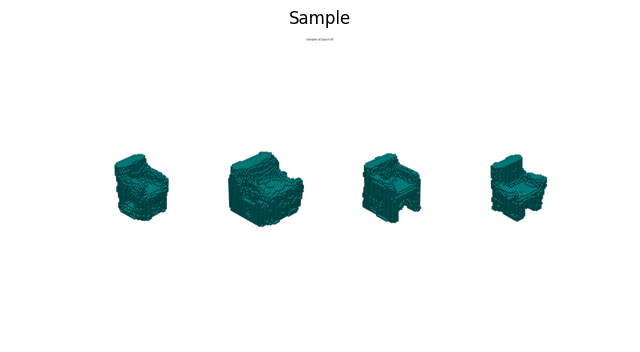

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

epoch_to_plot = 80
run_name = 'Colab-Chairs'

path_to_img = Path(f'vis/{run_name}/samples_epoch_{epoch_to_plot}.png')
img = Image.open(path_to_img)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title('Sample')
plt.axis('off')
plt.show()